In [1]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utilities import cal_score, cal_mape, cal_score_smooth

In [2]:
stack_idx = '19'
models = '1-34,36-37'
use_test_kfold = set([2, 7, 8, 12, 13])

is_per_area = False
add_intercept = True

### Read CV predictions and test

In [3]:
def parse_models(exp):
    exp_split = exp.split(',')
    idx_models = []
    for e in exp_split:
        if '-' in e:
            n0, n1 = e.split('-')
            idx_models.extend(list(range(int(n0), int(n1)+1, 1)))
        else:
            idx_models.append(int(e))
    return idx_models

In [4]:
idx_models = parse_models(models)
print(idx_models)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37]


In [5]:
files_in_output = [f for f in os.listdir('output/') if os.path.isfile('output/'+f)]
files_cv = {idx: [f for f in files_in_output 
                  if f.startswith('model-%02d-' % idx) and f.endswith('cv.csv')][0] 
            for idx in idx_models}
files_test_one = {idx: [f for f in files_in_output 
                        if f.startswith('model-%02d-' % idx) and f.endswith('test-one.csv')][0]
                  for idx in idx_models}
files_test_kf = {idx: [f for f in files_in_output 
                       if f.startswith('model-%02d-' % idx) and f.endswith('test-kfold.csv')][0]
                 for idx in idx_models}

In [6]:
for k in files_cv: 
    print('%2d'%k, files_cv[k])
    print('%2d'%k, files_test_kf[k])
    print('%2d'%k, files_test_one[k])

 1 model-01-lgb-cv.csv
 1 model-01-lgb-test-kfold.csv
 1 model-01-lgb-test-one.csv
 2 model-02-keras-search-cv.csv
 2 model-02-keras-search-test-kfold.csv
 2 model-02-keras-search-test-one.csv
 3 model-03-lgb-feats-selection-cv.csv
 3 model-03-lgb-feats-selection-test-kfold.csv
 3 model-03-lgb-feats-selection-test-one.csv
 4 model-04-lgb-PCA-cv.csv
 4 model-04-lgb-PCA-test-kfold.csv
 4 model-04-lgb-PCA-test-one.csv
 5 model-05-lgb-wo-per-area-cv.csv
 5 model-05-lgb-wo-per-area-test-kfold.csv
 5 model-05-lgb-wo-per-area-test-one.csv
 6 model-06-lgb-lr0.001-cv.csv
 6 model-06-lgb-lr0.001-test-kfold.csv
 6 model-06-lgb-lr0.001-test-one.csv
 7 model-07-keras-embedding-cv.csv
 7 model-07-keras-embedding-test-kfold.csv
 7 model-07-keras-embedding-test-one.csv
 8 model-08-keras-search-long-cv.csv
 8 model-08-keras-search-long-test-kfold.csv
 8 model-08-keras-search-long-test-one.csv
 9 model-09-lgb-feats-selection-75-cv.csv
 9 model-09-lgb-feats-selection-75-test-kfold.csv
 9 model-09-lgb-fea

#### Load area

In [7]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

In [8]:
cv = df_train[['building_id', 'building_area', 'total_price']]
test = df_test[['building_id', 'building_area']]

In [9]:
print('CV predictions:')
print(len(idx_models))
for i, idx_model in enumerate(idx_models):
    f = files_cv[idx_model]
    print(f)
#    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)
    
    cv = pd.merge(cv, df[['building_id', 'total_price_predict']], on='building_id')
    
    cv = cv.rename(columns = {'total_price_predict': 'pred_{}'.format(idx_model)})
    cv[f'log_pred_{idx_model}'] = np.log1p(cv[f'pred_{idx_model}'])
    cv[f'log_parea_pred_{idx_model}'] = np.log1p( cv[f'pred_{idx_model}'] / cv['building_area'] )

CV predictions:
36
model-01-lgb-cv.csv
model-02-keras-search-cv.csv
model-03-lgb-feats-selection-cv.csv
model-04-lgb-PCA-cv.csv
model-05-lgb-wo-per-area-cv.csv
model-06-lgb-lr0.001-cv.csv
model-07-keras-embedding-cv.csv
model-08-keras-search-long-cv.csv
model-09-lgb-feats-selection-75-cv.csv
model-10-lgb-feats-selection-75-lr-0.001-cv.csv
model-11-rf-cv.csv
model-12-predict-keras-search-prelu-cv.csv
model-13-predict-keras-he_uni-cv.csv
model-14-lgb-feats-selection-75-lr-0.001-rand-cv.csv
model-15-lgb-feats-selection-75-lr-0.001-rand323-cv.csv
model-16-lgb-feats-selection-68-lr-0.001-mix5-cv.csv
model-17-lgb-feats-selection-70-lr-0.001-mix5-cv.csv
model-18-lgb-feats-selection-70-lr-0.001-p5-cv.csv
model-19-lgb-search-bins-lr-0.0005-cv.csv
model-20-lgb-lr-0.0008-mix5-cv.csv
model-21-lgb-wo-per-area-long-cv.csv
model-22-lgb-wo-per-area-long-2-cv.csv
model-23-lgb-binary-cv.csv
model-24-lgb-binary-augment-cv.csv
model-25-lgb-search-bins-lr-0.0005-250-cv.csv
model-26-lgb-search-bins-lr-0.000

In [10]:
cv['log_total_price'] = np.log1p(cv['total_price'])
cv['log_parea_total_price'] = np.log1p( cv['total_price'] / cv['building_area'] )

print('Test predictions:')
for i, idx in enumerate(idx_models):
    f = files_test_kf[idx] if idx in use_test_kfold else files_test_one[idx]
    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)

    test = pd.merge(test, df[['building_id','total_price']], on='building_id')
        
    test = test.rename(columns = {'total_price': 'pred_{}'.format(idx)})
    test[f'log_pred_{idx}'] = np.log1p(test[f'pred_{idx}'])
    test[f'log_parea_pred_{idx}'] = np.log1p( test[f'pred_{idx}'] / test['building_area'] )

Test predictions:
No. 0 file: model-01-lgb-test-one.csv
No. 1 file: model-02-keras-search-test-kfold.csv
No. 2 file: model-03-lgb-feats-selection-test-one.csv
No. 3 file: model-04-lgb-PCA-test-one.csv
No. 4 file: model-05-lgb-wo-per-area-test-one.csv
No. 5 file: model-06-lgb-lr0.001-test-one.csv
No. 6 file: model-07-keras-embedding-test-kfold.csv
No. 7 file: model-08-keras-search-long-test-kfold.csv
No. 8 file: model-09-lgb-feats-selection-75-test-one.csv
No. 9 file: model-10-lgb-feats-selection-75-lr-0.001-test-one.csv
No. 10 file: model-11-rf-test-one.csv
No. 11 file: model-12-predict-keras-search-prelu-test-kfold.csv
No. 12 file: model-13-predict-keras-he_uni-test-kfold.csv
No. 13 file: model-14-lgb-feats-selection-75-lr-0.001-rand-test-one.csv
No. 14 file: model-15-lgb-feats-selection-75-lr-0.001-rand323-test-one.csv
No. 15 file: model-16-lgb-feats-selection-68-lr-0.001-mix5-test-one.csv
No. 16 file: model-17-lgb-feats-selection-70-lr-0.001-mix5-test-one.csv
No. 17 file: model-18-l

In [11]:
display(cv.head())
display(test.head())

,building_id,building_area,total_price,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,...,log_pred_34,log_parea_pred_34,pred_36,log_pred_36,log_parea_pred_36,pred_37,log_pred_37,log_parea_pred_37,log_total_price,log_parea_total_price
0,e3mMIMR3JJqCaXz1,3.418175,6.476038e+05,6.331552e+05,13.358472,12.129369,717209.94,13.483125,12.254022,6.656891e+05,...,13.360546,12.131443,6.245441e+05,13.344779,12.115676,6.319899e+05,13.356630,12.127527,13.381036,12.151933
1,LgwzgklNvy4QCtq5,4.041309,3.321452e+06,3.064324e+06,14.935338,13.538770,2899842.20,14.880167,13.483600,3.079196e+06,...,14.934792,13.538225,3.042045e+06,14.928041,13.531473,3.142342e+06,14.960479,13.563912,15.015913,13.619345
2,ucIR2NLLsC3T650L,5.584279,9.570885e+06,9.827776e+06,16.100723,14.380769,9766813.00,16.094501,14.374546,9.814852e+06,...,16.111430,14.391475,9.818275e+06,16.099756,14.379801,9.946933e+06,16.112775,14.392820,16.074236,14.354282
3,jre1pJhcQj91Kdky,13.563031,1.421501e+07,1.255350e+07,16.345510,13.738164,12699800.00,16.357097,13.749750,1.255981e+07,...,16.360720,13.753373,1.264691e+07,16.352924,13.745577,1.295773e+07,16.377203,13.769857,16.469809,13.862462
4,rQpYpY9nRG7X5mmr,4.688108,7.627120e+05,1.215194e+06,14.010415,12.465389,2012610.50,14.514944,12.969916,1.128419e+06,...,13.833961,12.288935,9.305770e+05,13.743561,12.198536,9.859947e+05,13.801407,12.256382,13.544637,11.999613


,building_id,building_area,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,log_pred_3,...,log_parea_pred_33,pred_34,log_pred_34,log_parea_pred_34,pred_36,log_pred_36,log_parea_pred_36,pred_37,log_pred_37,log_parea_pred_37
0,X5gsdTWGS3W7JJQB,3.418175,1.526912e+07,16.541343,15.312236,12470072.0,16.338842,15.109735,1.531685e+07,16.544464,...,15.177853,1.265085e+07,16.353235,15.124128,1.298618e+07,16.379396,15.150290,1.304845e+07,16.384180,15.155073
1,BTshNOJyKHnT2YIT,7.726227,3.924241e+06,15.182684,13.138065,3916552.2,15.180723,13.136104,3.977095e+06,15.196062,...,13.129452,3.890897e+06,15.174151,13.129532,3.897411e+06,15.175823,13.131204,3.897545e+06,15.175858,13.131239
2,dhdymr0lV8N5kZOT,12.170581,1.096127e+07,16.209879,13.710858,11912735.0,16.293119,13.794098,1.084967e+07,16.199646,...,13.676769,1.078313e+07,16.193493,13.694473,1.049745e+07,16.166643,13.667623,1.035078e+07,16.152573,13.653552
3,VEwyGGMcD56w5BOc,2.252256,6.155550e+06,15.632865,14.820933,5940670.0,15.597333,14.785400,6.015238e+06,15.609807,...,14.815015,6.080412e+06,15.620583,14.808651,6.139949e+06,15.630327,14.818395,6.120593e+06,15.627170,14.815237
4,wmUeMoJZfsqaSX9b,5.813985,1.062995e+06,13.876602,12.116340,1088488.1,13.900301,12.140039,1.027248e+06,13.842395,...,12.159895,1.092040e+06,13.903559,12.143297,1.106728e+06,13.916919,12.156657,1.098338e+06,13.909310,12.149048


### Check models scores

In [12]:
for i, idx_model in enumerate(idx_models):
    print('%2d'%i, 'model-%02d'%idx_model, '%.6f'%cal_score(cv['total_price'], cv[f'pred_{idx_model}']))

 0 model-01 5870.873059
 1 model-02 5400.852164
 2 model-03 5877.873452
 3 model-04 5713.867808
 4 model-05 5724.869598
 5 model-06 5886.873769
 6 model-07 5171.836449
 7 model-08 5514.858826
 8 model-09 5872.873118
 9 model-10 5897.873845
10 model-11 5075.838018
11 model-12 5486.856963
12 model-13 5506.858055
13 model-14 5908.873901
14 model-15 5900.873836
15 model-16 5907.874126
16 model-17 5905.874165
17 model-18 5908.874297
18 model-19 5911.874156
19 model-20 5908.874040
20 model-21 5758.870702
21 model-22 5752.870671
22 model-23 5852.871357
23 model-24 5866.873835
24 model-25 5908.874238
25 model-26 5918.873998
26 model-27 5892.873194
27 model-28 5901.874202
28 model-29 5884.873848
29 model-30 5864.872101
30 model-31 5783.868923
31 model-32 5930.875106
32 model-33 5976.875715
33 model-34 5942.875172
34 model-36 5989.876236
35 model-37 5980.875836


In [13]:
cv['constant_1'] = 1
test['constant_1'] = 1

if is_per_area:
    cols_opt = [f'log_parea_pred_{idx}' for idx in idx_models]
else:
    cols_opt = [f'log_pred_{idx}' for idx in idx_models]

if add_intercept:
    cols_opt.append('constant_1')

### Define opt function

In [14]:
def objective(x, cv, metric, best_score, best_coeffs, verbose):
    cv_pred_final = cv.loc[:, cols_opt].dot(x)
    
    if is_per_area:
        cv_pred_final = np.expm1(cv_pred_final) * cv['building_area']
    else:
        cv_pred_final = np.expm1(cv_pred_final)

    score = cal_score(cv['total_price'], cv_pred_final)
    if score > best_score[metric]:
        best_score[metric] = score
        best_coeffs[metric] = x.copy()
        if verbose:
            print('find better score:')
            print('score: ', score)
            print('coeffs: ', x)
            print()
    
    if metric == 'mape':
        return cal_mape(cv['total_price'], cv_pred_final)
    elif metric == 'mse':
        return mean_squared_error(cv['total_price'], cv_pred_final)
    elif metric == 'mae':
        return mean_absolute_error(cv['total_price'], cv_pred_final)
    elif metric == 'smooth':
        return cal_score_smooth(cv['total_price'], cv_pred_final)
    else:
        raise Exception('metric unknown: {}'.format(metric))
#    return 1 - (cal_score(cv['total_price'], cv_pred_final)/10000)

### Initialization

In [15]:
len_x = len(cols_opt)
rev_len_x = 1/len_x
x0s = [[1/len_x for i in range(len_x)],
       [0 for i in range(len_x)],
       [0.1 for i in range(len_x)],
       [0.2 for i in range(len_x)],
       [0.5 for i in range(len_x)],
       [np.random.randn()+1/len_x for i in range(len_x)],
       [np.random.randn()+1/len_x for i in range(len_x)],
       [np.random.randn()+1/len_x for i in range(len_x)] ]

### CV
(not run yet)

In [16]:
from sklearn.model_selection import KFold

cv = cv.reset_index(drop=True)
#cv = cv.head(100)

score_list = []

kf = KFold(shuffle= True)
for idx_train, idx_val in kf.split(cv):

    best_score = {}
    best_coeffs = {}
    cv_train = cv.loc[idx_train].reset_index(drop=True)    
    cv_val = cv.loc[idx_val].reset_index(drop=True)    

    for metric in ['smooth']:
    #for metric in ['mape', 'mae', 'mse']:
        best_score[metric] = 0
        best_coeffs[metric] = []
        for x0 in x0s:
            print('Optimizing with init x0: {}'.format(x0))
            print()
            minimize(objective, x0, args=(cv_train, metric, best_score, best_coeffs, True), 
                     tol=1e-4)
    
    val_pred_final = cv_val.loc[:, cols_opt].dot(best_coeffs['smooth'])
    if is_per_area:
        val_pred_final = np.expm1(val_pred_final) * cv_val['building_area']
    else:
        val_pred_final = np.expm1(val_pred_final)
    score = cal_score(cv_val['total_price'], val_pred_final)
    
    score_list.append(score)

print('CV score ?: {}; {}'.format(np.mean(score_list), score_list))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


Optimizing with init x0: [0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776, 0.027777777777777776]

find better score:
score:  316.6676953052345
coeffs:  [0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02

find better score:
score:  4772.859387598942
coeffs:  [0.02836166 0.02836115 0.02836161 0.02836172 0.02836164 0.02836165
 0.02836099 0.02836128 0.02836165 0.02836165 0.02836259 0.02836153
 0.02836131 0.02836164 0.02836165 0.02836163 0.02836164 0.02836163
 0.02836163 0.02836161 0.02836165 0.02836164 0.0283616  0.02836158
 0.02836161 0.02836165 0.02836157 0.02836162 0.02836159 0.02836156
 0.02836154 0.02836152 0.02836132 0.02836151 0.02836132 0.02781644]

find better score:
score:  4772.859387598962
coeffs:  [0.02836166 0.02836115 0.02836161 0.02836172 0.02836164 0.02836165
 0.02836099 0.02836128 0.02836165 0.02836165 0.02836259 0.02836153
 0.02836131 0.02836164 0.02836165 0.02836163 0.02836164 0.02836163
 0.02836163 0.02836161 0.02836165 0.02836164 0.0283616  0.02836158
 0.02836161 0.02836165 0.02836157 0.02836162 0.02836159 0.02836156
 0.02836154 0.02836151 0.02836133 0.02836151 0.02836132 0.02781644]

find better score:
score:  4772.859387598966
coeffs:  [0.02836166 0.02836115 0.02836

Optimizing with init x0: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/linesearch.py:155: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/linesearch.py:391: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


Optimizing with init x0: [0.5296192548569031, -0.9371895353230894, -0.937782584245267, 1.5051239908388594, 0.2682545889816639, -0.39513019292116663, 2.1560102662949943, -0.5300149607758173, -0.11841795479293817, 0.6991482453445154, -0.3971180916176833, 0.37286582385556805, 0.13391331805604773, -1.9326251679873185, -0.24907812605901813, -0.2716424211126901, -1.8998021279247215, 1.365622108378165, -1.086939526750787, -0.9598221340588567, -0.7083807506098937, 0.21266001611492552, 0.8025648990432044, -0.16037162248885828, 1.2713160985178509, -2.406032723460554, 0.7754076992366479, 0.18801960053065064, -1.5337913123936417, 0.4017279998915864, 0.16850958447984776, -1.7180723072432242, 0.0219262271160703, -1.64892186807067, -0.35597841400212404, 1.615729922206366]

Optimizing with init x0: [-0.6560746872140686, -1.4173482932309656, 1.4794494243477476, 0.25591375080612583, 0.7038560308999772, -0.5565574074534013, 0.5100507029745771, -0.2240835057924097, 1.0328947357163731, -0.00830674639253912

find better score:
score:  1582.7918804016447
coeffs:  [0.02813779 0.02813758 0.02813776 0.02813787 0.0281378  0.02813778
 0.02813735 0.02813777 0.02813774 0.02813778 0.02813823 0.02813777
 0.0281377  0.02813778 0.02813778 0.02813777 0.02813778 0.02813777
 0.02813778 0.02813777 0.02813782 0.0281378  0.02813776 0.02813776
 0.02813776 0.02813778 0.02813771 0.02813776 0.02813773 0.02813773
 0.02813775 0.02813774 0.02813762 0.02813775 0.02813759 0.0278016 ]

find better score:
score:  1582.7918804016476
coeffs:  [0.02813779 0.02813758 0.02813776 0.02813787 0.0281378  0.02813778
 0.02813735 0.02813777 0.02813774 0.02813778 0.02813823 0.02813777
 0.0281377  0.02813778 0.02813778 0.02813777 0.02813778 0.02813777
 0.02813778 0.02813777 0.02813782 0.0281378  0.02813776 0.02813776
 0.02813776 0.02813778 0.02813771 0.02813776 0.02813773 0.02813773
 0.02813775 0.02813774 0.02813761 0.02813775 0.0281376  0.0278016 ]

find better score:
score:  3083.806378783867
coeffs:  [0.02875051 0.02874994 0.028

find better score:
score:  6036.87839911947
coeffs:  [-0.06766324 -0.03886579  0.02389715 -0.04313299  0.0924571   0.03336228
  0.04052155  0.06844715  0.03062635 -0.02026075 -0.12388892  0.06146488
  0.03059333  0.00888292  0.01980006  0.0183511   0.03100325  0.00088144
 -0.1578485  -0.17259135  0.04878201 -0.01797549  0.07676916  0.08297944
 -0.1862173  -0.0541503   0.28852166 -0.11100297  0.00967702  0.11740517
  0.17176895 -0.03871072  0.32612174 -0.02829974  0.47967146 -0.02614481]

find better score:
score:  6042.878476152836
coeffs:  [-0.0166557   0.00845916  0.03688234 -0.00887603  0.07296252  0.05668365
  0.03277522  0.05968722  0.0691604  -0.02259758 -0.13658995  0.03439611
  0.03662461 -0.00126161  0.00401335  0.00662339  0.00870323 -0.00439898
 -0.13403938 -0.15388776  0.02872991 -0.02124391  0.03514495  0.0610369
 -0.15964343 -0.04755943  0.27383421 -0.11541295 -0.00886308  0.07357497
  0.10426927 -0.00828502  0.35480931 -0.00283511  0.48651836 -0.04710601]

find better sc

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/linesearch.py:155: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/linesearch.py:391: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


Optimizing with init x0: [0.5296192548569031, -0.9371895353230894, -0.937782584245267, 1.5051239908388594, 0.2682545889816639, -0.39513019292116663, 2.1560102662949943, -0.5300149607758173, -0.11841795479293817, 0.6991482453445154, -0.3971180916176833, 0.37286582385556805, 0.13391331805604773, -1.9326251679873185, -0.24907812605901813, -0.2716424211126901, -1.8998021279247215, 1.365622108378165, -1.086939526750787, -0.9598221340588567, -0.7083807506098937, 0.21266001611492552, 0.8025648990432044, -0.16037162248885828, 1.2713160985178509, -2.406032723460554, 0.7754076992366479, 0.18801960053065064, -1.5337913123936417, 0.4017279998915864, 0.16850958447984776, -1.7180723072432242, 0.0219262271160703, -1.64892186807067, -0.35597841400212404, 1.615729922206366]

Optimizing with init x0: [-0.6560746872140686, -1.4173482932309656, 1.4794494243477476, 0.25591375080612583, 0.7038560308999772, -0.5565574074534013, 0.5100507029745771, -0.2240835057924097, 1.0328947357163731, -0.00830674639253912

find better score:
score:  1667.7949961985112
coeffs:  [0.02814995 0.02814973 0.02814994 0.02815008 0.02814995 0.02814993
 0.02814945 0.02814991 0.02814994 0.02814994 0.02815057 0.02814997
 0.02814991 0.02814994 0.02814994 0.02814993 0.02814994 0.02814993
 0.02814992 0.02814992 0.02814995 0.02814994 0.02814993 0.02814987
 0.02814991 0.02814994 0.02814988 0.02814992 0.0281499  0.0281499
 0.02814986 0.02814987 0.02814974 0.02814987 0.02814971 0.02780242]

find better score:
score:  1667.7949961985141
coeffs:  [0.02814995 0.02814973 0.02814994 0.02815008 0.02814995 0.02814993
 0.02814945 0.02814991 0.02814994 0.02814994 0.02815057 0.02814997
 0.02814991 0.02814994 0.02814994 0.02814993 0.02814994 0.02814993
 0.02814992 0.02814992 0.02814995 0.02814994 0.02814993 0.02814987
 0.02814991 0.02814994 0.02814988 0.02814992 0.0281499  0.0281499
 0.02814986 0.02814987 0.02814973 0.02814987 0.02814973 0.02780242]

find better score:
score:  2816.7953651015832
coeffs:  [0.02877091 0.02877032 0.0287

find better score:
score:  5992.876054761915
coeffs:  [ 0.00237776  0.06908767  0.00724482 -0.00299515  0.14690868  0.00724921
  0.03758432  0.09643066  0.01638221 -0.03911983 -0.10174127 -0.01633991
  0.01239314 -0.0331325  -0.03097867 -0.0165311  -0.00250283 -0.01036239
 -0.05014687 -0.07689048  0.02873163  0.01166795 -0.0230086   0.06238244
 -0.06046433 -0.007651    0.08260714 -0.06300086 -0.07947559  0.01846938
  0.07063867  0.09337039  0.32529622  0.09624613  0.42529611  0.06042836]

find better score:
score:  5993.8760838294575
coeffs:  [-0.0033572   0.02631249 -0.00218373  0.01334835  0.08685065 -0.00037882
  0.05341171  0.08236959  0.00493941 -0.02634852 -0.04044189 -0.0111154
  0.01831176 -0.02319993 -0.0211915  -0.00992943 -0.0013335  -0.00248158
 -0.01998897 -0.04062447  0.01363378  0.00288038  0.00732702  0.06152731
 -0.02739946  0.00738076  0.06345431 -0.03337806 -0.04558031  0.03843054
  0.05968962  0.09712     0.25438056  0.09906321  0.31761974  0.01338907]

find better 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/linesearch.py:155: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/linesearch.py:391: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


Optimizing with init x0: [0.5296192548569031, -0.9371895353230894, -0.937782584245267, 1.5051239908388594, 0.2682545889816639, -0.39513019292116663, 2.1560102662949943, -0.5300149607758173, -0.11841795479293817, 0.6991482453445154, -0.3971180916176833, 0.37286582385556805, 0.13391331805604773, -1.9326251679873185, -0.24907812605901813, -0.2716424211126901, -1.8998021279247215, 1.365622108378165, -1.086939526750787, -0.9598221340588567, -0.7083807506098937, 0.21266001611492552, 0.8025648990432044, -0.16037162248885828, 1.2713160985178509, -2.406032723460554, 0.7754076992366479, 0.18801960053065064, -1.5337913123936417, 0.4017279998915864, 0.16850958447984776, -1.7180723072432242, 0.0219262271160703, -1.64892186807067, -0.35597841400212404, 1.615729922206366]

Optimizing with init x0: [-0.6560746872140686, -1.4173482932309656, 1.4794494243477476, 0.25591375080612583, 0.7038560308999772, -0.5565574074534013, 0.5100507029745771, -0.2240835057924097, 1.0328947357163731, -0.00830674639253912

### Optimize

In [16]:
best_score = {}
best_coeffs = {}

for metric in ['smooth']:
#for metric in ['mape', 'mae', 'mse']:
    best_score[metric] = 0
    best_coeffs[metric] = []
    for x0 in x0s:
        print('Optimizing with init x0: {}'.format(x0))
        print()
        minimize(objective, x0, args=(cv, metric, best_score, best_coeffs, True), 
                 tol=1e-4)

Optimizing with init x0: [0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703]

find better score:
score:  340.67387541056735
coeffs:  [0.02702703 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703
 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703
 0.0270

find better score:
score:  5819.874426562521
coeffs:  [0.02767382 0.02767343 0.02767379 0.02767394 0.02767381 0.02767381
 0.02767305 0.02767365 0.02767378 0.0276738  0.02767479 0.02767377
 0.02767363 0.02767379 0.0276738  0.02767379 0.0276738  0.02767379
 0.02767379 0.02767378 0.02767382 0.0276738  0.02767378 0.02767375
 0.02767377 0.0276738  0.0276737  0.02767377 0.02767374 0.02767373
 0.02767372 0.02767371 0.0276735  0.02767372 0.02767348 0.0276734
 0.02706982]

find better score:
score:  5819.874426597038
coeffs:  [0.02767384 0.02767343 0.02767379 0.02767394 0.02767381 0.02767381
 0.02767305 0.02767365 0.02767378 0.0276738  0.02767479 0.02767377
 0.02767363 0.02767379 0.0276738  0.02767379 0.0276738  0.02767379
 0.02767379 0.02767378 0.02767382 0.0276738  0.02767378 0.02767375
 0.02767377 0.0276738  0.0276737  0.02767377 0.02767374 0.02767373
 0.02767372 0.02767371 0.0276735  0.02767372 0.02767348 0.0276734
 0.02706982]

find better score:
score:  5819.8744265970545
coeffs:  [0.0276

find better score:
score:  6010.877197853795
coeffs:  [-0.00933461 -0.02197229 -0.00725128  0.02351482  0.06599009 -0.00174739
  0.0662644   0.05620947 -0.00221402 -0.01327564 -0.01159589 -0.0118477
  0.02526846 -0.01341481 -0.01089919 -0.00575708 -0.00357147 -0.0003146
 -0.00928374 -0.02034106  0.03666956  0.03299503  0.02189823  0.03727274
 -0.01394065  0.00536537  0.05422351 -0.01993302 -0.01224783  0.04012203
  0.05120486  0.06770538  0.15455895  0.06795483  0.18721598  0.19813321
 -0.05482642]

find better score:
score:  6023.877521916309
coeffs:  [-0.00344963  0.02580841  0.00411028  0.00139227  0.07259131  0.00993321
  0.00307635  0.0834301   0.00935574 -0.02590438 -0.04302406 -0.00770181
  0.05948654 -0.02295633 -0.02060708 -0.0159376  -0.0123862  -0.01663967
 -0.05851587 -0.07303702  0.00807785 -0.00194616  0.00580287  0.02535272
 -0.06862088 -0.02407445  0.11338234 -0.06911248 -0.03681984  0.02990351
  0.07137194  0.04553101  0.22825239  0.04673649  0.30840049  0.34849565
  0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/linesearch.py:155: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/linesearch.py:391: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


Optimizing with init x0: [-0.5110538151163169, -0.779137004052016, -0.5245302523817306, -1.1059505691350153, 0.5772175548489449, -0.3637734129281973, -0.1312112325993625, -0.31152692206811544, -0.43432074211750976, 0.0932704656230493, 1.4013895176194635, 0.41747807990123115, 0.5229160105745478, 2.406032710215061, 0.013925868647892805, 0.7783662708654133, -0.04378145193332958, -0.3005441744026727, 0.5039142510451475, 0.12192632015568851, 0.365678263655977, -0.7125800689100064, 2.595275937692595, -0.9038271655463739, -0.8403568734545275, 0.19240272941754952, 0.5671992220101669, 1.038251789749634, 0.20054562015223534, 1.05483101743814, -0.7283547014969391, 0.8310036404356429, 0.5483362676755528, 1.0426639387294836, -0.14011907443967725, -0.8234573774667291, 1.5201690945769544]

find better score:
score:  6050.878567989163
coeffs:  [-0.05895754  0.01873386  0.05347019 -0.00120608  0.14629173  0.01539391
  0.02811907  0.06914767 -0.02869167 -0.13783333 -0.11178092 -0.00431743
  0.04164938 -

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in expm1
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in expm1
  import sys


In [17]:
display(best_score)
display(best_coeffs)

{'smooth': 6050.878567989163}

{'smooth': array([-0.05895754,  0.01873386,  0.05347019, -0.00120608,  0.14629173,
         0.01539391,  0.02811907,  0.06914767, -0.02869167, -0.13783333,
        -0.11178092, -0.00431743,  0.04164938, -0.23846654,  0.16510956,
         0.01184705,  0.40731065, -0.10718031, -0.34983805, -0.1526613 ,
         0.05421626, -0.14411474,  0.04332266,  0.0990424 , -0.39636906,
         0.23875528,  0.24257175,  0.15150372, -0.01138854,  0.06881788,
         0.07320174, -0.19542414, -0.2313475 ,  0.15590604,  0.46625188,
         0.62145557, -0.04331352])}

### Compute submission

In [ ]:
test_pred_final = pd.DataFrame({'building_id': test['building_id']})

test_pred_final['total_price'] = test.loc[:,cols_opt].dot(best_coeffs['smooth'])

if is_per_area:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price']) * test['building_area'] 
else:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price'])
    
test_pred_final['total_price'] = np.clip(test_pred_final['total_price'], 0, None)

In [23]:
unique_prices = np.sort(df_train['total_price'].unique())

def find_nearest(array, value):
    return array[(np.fabs(array - value)).argmin()]

def correct_prices(sq):
    return [find_nearest(unique_prices, x) for x in sq]

test_pred_final['total_price'] = correct_prices(test_pred_final['total_price'])

In [24]:
if is_per_area:
    test_pred_final.to_csv('output/stack_spopt-parea_{}_{}_smoothobj.csv'.format(stack_idx, models), index=False)
else:
    test_pred_final.to_csv('output/stack_spopt_{}_{}_smoothobj.csv'.format(stack_idx, models), index=False)

### Plots

In [19]:
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


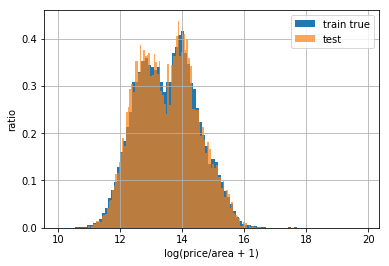

In [25]:
plt.hist(cv['log_parea_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price'] / test['building_area']), bins=100, label='test',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


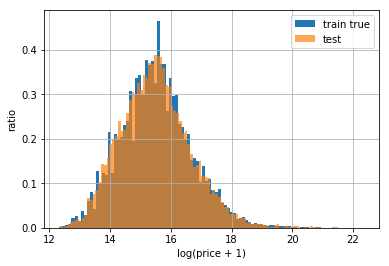

In [26]:
plt.hist(cv['log_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


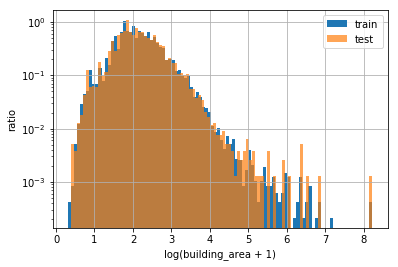

In [27]:
plt.hist(np.log1p(cv['building_area']), bins=100, label='train', normed=True)
plt.hist(np.log1p(test['building_area']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(building_area + 1)'); plt.ylabel('ratio'); plt.yscale('log')
plt.legend(); plt.grid(); plt.show()

### mean log

In [23]:
idxs = [3, 5, 8, 12, 13, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31]
print([1/len(idxs) if i in idxs else 0 for i in range(1,32)])

[0, 0, 0.05263157894736842, 0, 0.05263157894736842, 0, 0, 0.05263157894736842, 0, 0, 0, 0.05263157894736842, 0.05263157894736842, 0, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0, 0.05263157894736842, 0, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0, 0.05263157894736842]


### mean

In [24]:
idxs = [5, 12, 16, 23, 24, 25, 27, 31]
print([1/len(idxs) if i in idxs else 0 for i in range(1,32)])

[0, 0, 0, 0, 0.125, 0, 0, 0, 0, 0, 0, 0.125, 0, 0, 0, 0.125, 0, 0, 0, 0, 0, 0, 0.125, 0.125, 0.125, 0, 0.125, 0, 0, 0, 0.125]
